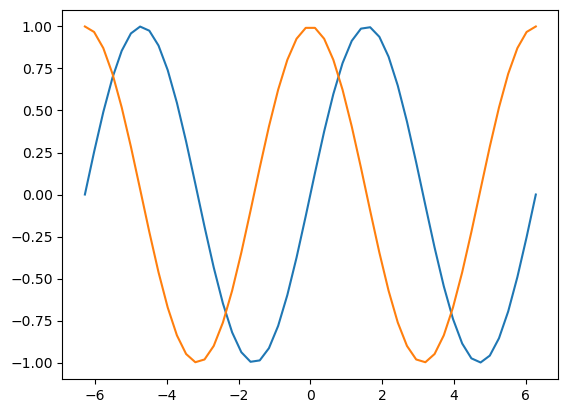

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt

axis_x = np.linspace(-2*np.pi, 2*np.pi)
sin_data = np.sin(axis_x)
cos_data = np.cos(axis_x)

plt.plot(axis_x, sin_data)
plt.plot(axis_x, cos_data)
plt.show()

n_rnn = 10
n_sample = len(axis_x) - n_rnn
x_encoder = np.zeros((n_sample, n_rnn))
x_decoder = np.zeros((n_sample, n_rnn))
t_decoder = np.zeros((n_sample, n_rnn))

for i in range(0, n_sample):
    x_encoder[i] = sin_data[i:i+n_rnn]
    x_decoder[i, 1:] = cos_data[i:i+n_rnn-1]
    t_decoder[i] = cos_data[i:i+n_rnn]

x_encoder = x_encoder.reshape(n_sample, n_rnn, 1)
x_decoder = x_decoder.reshape(n_sample, n_rnn, 1)
t_decoder = t_decoder.reshape(n_sample, n_rnn, 1)

In [3]:
from keras.models import Model
from keras.layers import Dense, LSTM, Input

n_in = 1
n_mid = 20
n_out = n_in

encoder_input = Input(shape=(n_rnn, n_in))
encoder_lstm = LSTM(n_mid, return_state=True)
encoder_output, encoder_state_h, encoder_state_c = encoder_lstm(encoder_input)
encoder_state = [encoder_state_h, encoder_state_c]

decoder_input = Input(shape=(n_rnn, n_in))
decoder_lstm = LSTM(n_mid, return_sequences=True, return_state=True)
decoder_output, _, _ = decoder_lstm(decoder_input, initial_state=encoder_state)
decoder_dense = Dense(n_out, activation='linear')
decoder_output = decoder_dense(decoder_output)

model = Model([encoder_input, decoder_input], decoder_output)
model.compile(loss="mean_squared_error", optimizer="adam")
print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 20),         1760        ['input_1[0][0]']                
                                 (None, 20),                                                      
                                 (None, 20)]                                                      
                                                                                              

2024-08-07 22:14:30.760480: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 22:14:30.761997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 22:14:30.762672: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [4]:
history = model.fit([x_encoder, x_decoder], t_decoder,
                    batch_size=8,
                    epochs=30)

Epoch 1/30


2024-08-07 22:16:20.857241: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2024-08-07 22:16:21.179814: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 22:16:21.181150: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 22:16:21.181915: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG IN

5/5 [==============================] - 2s 6ms/step - loss: 0.5839
Epoch 2/30
5/5 [==============================] - 0s 4ms/step - loss: 0.5363
Epoch 3/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4948
Epoch 4/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4582
Epoch 5/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4275
Epoch 6/30
5/5 [==============================] - 0s 3ms/step - loss: 0.4004
Epoch 7/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3752
Epoch 8/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3537
Epoch 9/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3341
Epoch 10/30
5/5 [==============================] - 0s 3ms/step - loss: 0.3156
Epoch 11/30
5/5 [==============================] - 0s 3ms/step - loss: 0.2976
Epoch 12/30
5/5 [==============================] - 0s 3ms/step - loss: 0.2798
Epoch 13/30
5/5 [==============================] - 0s 3ms/step - loss: 0.2615
Epoch 

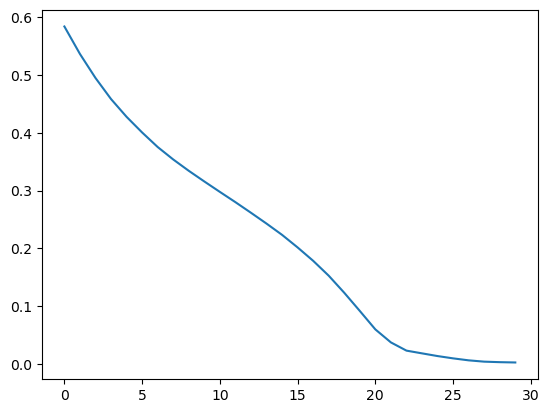

In [5]:
loss = history.history['loss']
plt.plot(np.arange(len(loss)), loss)
plt.show()

In [14]:
# encoderのモデルを構築
encoder_model = Model(encoder_input, encoder_state)  # 間にあるLSTM層は学習済み

# decoderのモデルを構築
decoder_input = Input(shape=(1, n_in))

decoder_state_in_h = Input(shape=(n_mid,))
decoder_state_in_c = Input(shape=(n_mid,))
decoder_state_in = [decoder_state_in_h, decoder_state_in_c]

decoder_output, decoder_state_h, decoder_state_c = decoder_lstm(decoder_input,  # 既存の学習済みLSTM層を使用
                                                                 initial_state=decoder_state_in)  
decoder_state = [decoder_state_h, decoder_state_c]

decoder_output = decoder_dense(decoder_output)  # 既存の学習済み全結合層を使用
decoder_model = Model([decoder_input] + decoder_state_in, [decoder_output] + decoder_state) # リストを+で結合


2024-08-07 22:48:25.826540: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 22:48:25.827891: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 22:48:25.828577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [15]:
def translate(input_data):
    state_value = encoder_model.predict(input_data)  # encoderから状態を取得
    y_decoder = np.zeros((1, 1, 1))  # 出力の値
    translated = []  # 翻訳結果
    
    for i in range(0, n_rnn):  # 各時刻ごとに予測を行う
        y, h, c = decoder_model.predict([y_decoder] + state_value)  # 前の時刻の出力と状態を渡す
        y = y[0][0][0]
        translated.append(y)
        y_decoder[0][0][0] = y  # 次の時刻に渡す値
        state_value = [h, c]  # 次の時刻に渡す状態

    return translated
    

1/1 [==============================] - 0s 222ms/step


2024-08-07 22:48:29.896387: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 22:48:29.897059: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 22:48:29.897683: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - ETA: 0s

2024-08-07 22:48:30.139858: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-08-07 22:48:30.140840: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-08-07 22:48:30.141515: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

1/1 [==============================] - 0s 18ms/step


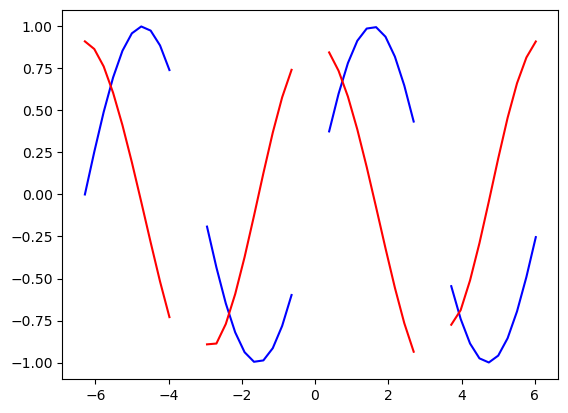

In [16]:
demo_idices = [0, 13, 26, 39]  # デモに使うデータのインデックス
for i in demo_idices:
    x_demo = x_encoder[i:i+1]  # 入力を一部取り出す
    y_demo = translate(x_demo)  # 翻訳する
    
    plt.plot(axis_x[i:i+n_rnn], x_demo.reshape(-1), color="b")  # 翻訳前（青）
    plt.plot(axis_x[i:i+n_rnn], y_demo, color="r")  # 翻訳後（赤）
    
plt.show() 